# Bayesian Optimization (V3)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

from bayesian_optimization import jit_plus_server, plot_example_gpr

plt.rc("figure", figsize=(16, 10))

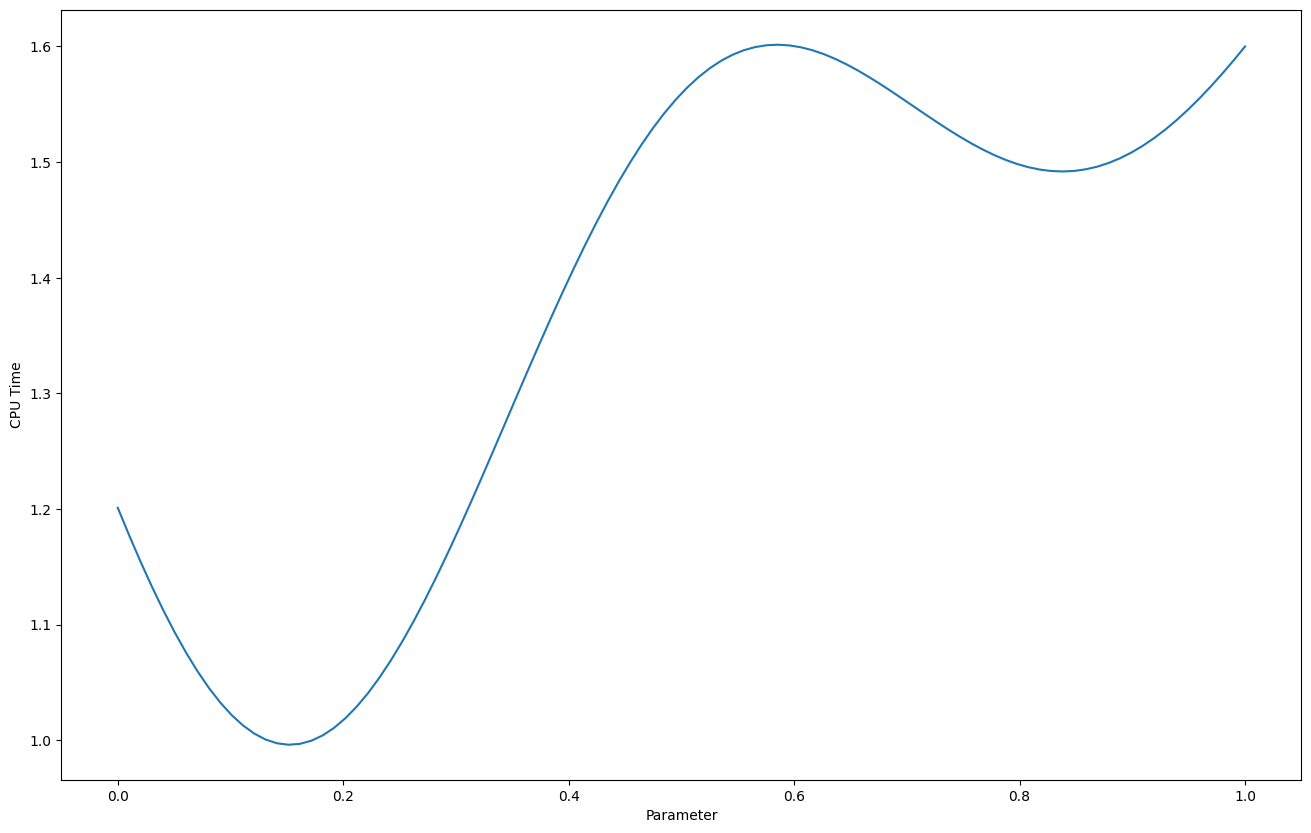

In [2]:
np.random.seed(20250127)


def jit_plus_server(parameters, is_noisy=False):
    x = np.array(parameters)
    d = len(x)
    x1 = x - 0.15 * np.ones(shape=(d,))
    x2 = x - 0.85 * np.ones(shape=(d,))
    cpu_time = 2 - np.exp(-10 * x1**2) - 0.5 * np.exp(-10 * x2**2)
    noise = 0.005 * np.random.normal()
    return cpu_time.mean() + is_noisy * noise


x = np.linspace(0, 1, 100)
y = [jit_plus_server([i]) for i in x]

plt.plot(x, y)
plt.xlabel("Parameter")
plt.ylabel("CPU Time");

In [3]:
# Optimal value (min).
i = np.argmin(y)
print("x={:.4f} | y={:.4f}".format(x[i], y[i]))

x=0.1515 | y=0.9962


Given an expensive black-box function, we can find the optimum value (minimizing) by trying all the different parameters.
By using bayesian optimization, we can reduce the number of trials before reaching the optimum value.

In [4]:
np.random.seed(20250127)


def objective(trial):
    x = trial.suggest_float("x", 0, 1)
    return jit_plus_server([x])


study = optuna.create_study()
study.optimize(objective, n_trials=16)

[I 2025-01-30 14:42:22,644] A new study created in memory with name: no-name-3ad6af9f-4aa9-42d3-97fb-1b1a7e7a1dd3
[I 2025-01-30 14:42:22,645] Trial 0 finished with value: 1.2387192470206816 and parameters: {'x': 0.3279755178882411}. Best is trial 0 with value: 1.2387192470206816.
[I 2025-01-30 14:42:22,645] Trial 1 finished with value: 1.532254907801371 and parameters: {'x': 0.9344055124501031}. Best is trial 0 with value: 1.2387192470206816.
[I 2025-01-30 14:42:22,646] Trial 2 finished with value: 1.5773892707340091 and parameters: {'x': 0.5200348750994868}. Best is trial 0 with value: 1.2387192470206816.
[I 2025-01-30 14:42:22,646] Trial 3 finished with value: 1.2580248740077669 and parameters: {'x': 0.3365190963516762}. Best is trial 0 with value: 1.2387192470206816.
[I 2025-01-30 14:42:22,646] Trial 4 finished with value: 0.9991686669222456 and parameters: {'x': 0.13519838743350332}. Best is trial 4 with value: 0.9991686669222456.
[I 2025-01-30 14:42:22,646] Trial 5 finished with v

In [5]:
study.best_params

{'x': 0.1666933421730653}

In [6]:
jit_plus_server([study.best_params["x"]])

0.9980923490251096

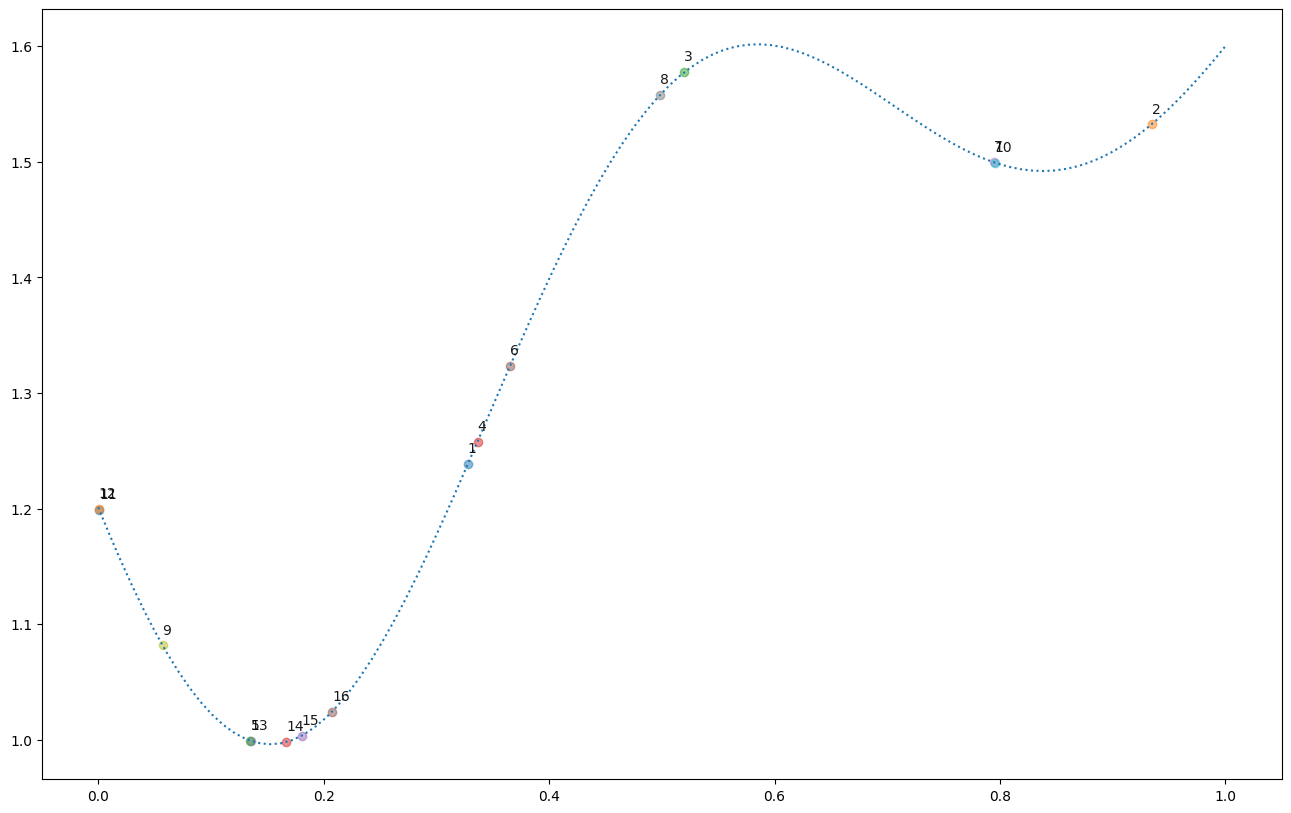

In [7]:
for t in study.trials:
    x_i = t.params["x"]
    y_i = t.values[0]
    text_i = t.number + 1
    plt.text(x_i, y_i + 0.01, text_i, alpha=0.9)
    plt.scatter(x_i, y_i, alpha=0.5)
plt.plot(x, y, linestyle="dotted");

In [8]:
def fit_gaussian_process(X: np.ndarray, y: np.ndarray):
    """https://www.miguelgondu.com/blogposts/2023-07-31/intro-to-bo/"""
    kernel = 1 * RBF() + WhiteKernel()
    model = GaussianProcessRegressor(kernel=kernel)
    model.fit(X, y)
    return model

In [9]:
X = [0, 0.5, 1]
y = [jit_plus_server([x]) for x in X]
X, y

([0, 0.5, 1], [1.2011197049710782, 1.5593634495147009, 1.600013738081222])

In [10]:
model = fit_gaussian_process(np.array(X).reshape(-1, 1), y)
model

/Users/alextanhongpin/Library/Caches/pypoetry/virtualenvs/python-experimentation-for-engineers-8u4RfFJH-py3.12/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1))

In [11]:
X_test = [0.25, 0.75]
y_test = [jit_plus_server([x]) for x in X_test]
y_pred = model.predict(np.array(X_test).reshape(-1, 1))
y_test, y_pred

([1.0815007207403942, 1.5202575685347275], array([1.4139729 , 1.62261357]))